In [27]:
import pandas as pd
import matplotlib.pyplot as plt

enrol_agg = pd.read_csv(
    "../data/processed/enrolment_aggregated.csv",
    parse_dates=['date']
)

demo_agg = pd.read_csv(
    "../data/processed/demographic_updates_aggregated.csv",
    parse_dates=['date']
)

bio_agg = pd.read_csv(
    "../data/processed/biometric_updates_aggregated.csv",
    parse_dates=['date']
)

print(enrol_agg.shape, demo_agg.shape, bio_agg.shape)


(66749, 6) (86125, 5) (79794, 5)


In [2]:
import pandas as pd

enrol = pd.read_csv("../data/processed/enrolment_aggregated.csv", parse_dates=['date'])
demo  = pd.read_csv("../data/processed/demographic_updates_aggregated.csv", parse_dates=['date'])
bio   = pd.read_csv("../data/processed/biometric_updates_aggregated.csv")

print(enrol.shape, demo.shape, bio.shape)


(66749, 6) (86125, 5) (79794, 5)


In [3]:
# Merge all three datasets on date, state, district
merged = (
    enrol
    .merge(demo, on=['date', 'state', 'district'], how='left')
    .merge(bio,  on=['date', 'state', 'district'], how='left')
)

# Replace NaNs from left joins with 0
merged.fillna(0, inplace=True)

print(merged.shape)
merged.head()


(66749, 10)


,date,state,district,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_plus,bio_age_5_17,bio_age_17_plus
0,01-04-2025,Assam,Baksa,408,483,187,0.0,0.0,2598.0,474.0
1,01-04-2025,Assam,Barpeta,138,54,23,0.0,0.0,9902.0,2067.0
2,01-04-2025,Assam,Biswanath,104,114,32,0.0,0.0,1463.0,323.0
3,01-04-2025,Assam,Bongaigaon,221,87,61,348.0,4007.0,4512.0,1135.0
4,01-04-2025,Assam,Cachar,988,461,299,0.0,0.0,9483.0,2866.0


In [4]:
# Total updates
merged['total_updates'] = (
    merged['demo_age_5_17'] +
    merged['demo_age_17_plus'] +
    merged['bio_age_5_17'] +
    merged['bio_age_17_plus']
)

# Total new enrolments
merged['total_enrolments'] = (
    merged['age_0_5'] +
    merged['age_5_17'] +
    merged['age_18_greater']
)

# Update Stress Index
merged['USI'] = merged['total_updates'] / merged['total_enrolments']


In [5]:
merged[['state', 'district', 'USI']] \
    .sort_values('USI', ascending=False) \
    .head(10)


,state,district,USI
7416,Maharashtra,Nashik,11082.0
7406,Maharashtra,Ahmadnagar,10615.0
7418,Maharashtra,Parbhani,5316.0
7414,Maharashtra,Nanded,5259.0
7508,Tamil Nadu,Tiruvallur,4841.0
7411,Maharashtra,Latur,4747.0
7422,Maharashtra,Solapur,4303.0
7502,Tamil Nadu,Kancheepuram,4278.0
7518,Telangana,Mahabubnagar,3945.0
7410,Maharashtra,Jalna,3887.0


In [6]:
merged['CLCS'] = merged['bio_age_5_17'] / merged['age_5_17']

# Cap extreme values (safe governance practice)
merged['CLCS'] = merged['CLCS'].clip(lower=0, upper=1)


In [7]:
merged[['state', 'district', 'CLCS']] \
    .sort_values('CLCS') \
    .head(10)


,state,district,CLCS
66738,West Bengal,Paschim Medinipur,0.0
66710,Uttarakhand,Uttarkashi,0.0
66709,Uttarakhand,Udham Singh Nagar,0.0
66708,Uttarakhand,Tehri Garhwal,0.0
66707,Uttarakhand,Rudraprayag,0.0
66706,Uttarakhand,Pithoragarh,0.0
66705,Uttarakhand,Pauri Garhwal,0.0
66704,Uttarakhand,Nainital,0.0
66703,Uttarakhand,Haridwar,0.0
66701,Uttarakhand,Dehradun,0.0


In [8]:
merged['EQS'] = 1 - (merged['bio_age_17_plus'] / merged['age_18_greater'])

merged['EQS'] = merged['EQS'].clip(lower=0, upper=1)


In [9]:
merged[['state', 'district', 'EQS']] \
    .sort_values('EQS') \
    .head(10)


,state,district,EQS
19,Assam,Karimganj,0.0
46,Bihar,West Champaran,0.0
45,Bihar,Vaishali,0.0
44,Bihar,Sitamarhi,0.0
43,Bihar,Saran,0.0
42,Bihar,Purnia,0.0
41,Bihar,Patna,0.0
40,Bihar,Muzaffarpur,0.0
39,Bihar,Munger,0.0
38,Bihar,Madhubani,0.0


<Axes: title={'center': 'Aadhaar Pulse – Temporal Signals (Baksa)'}, xlabel='date'>

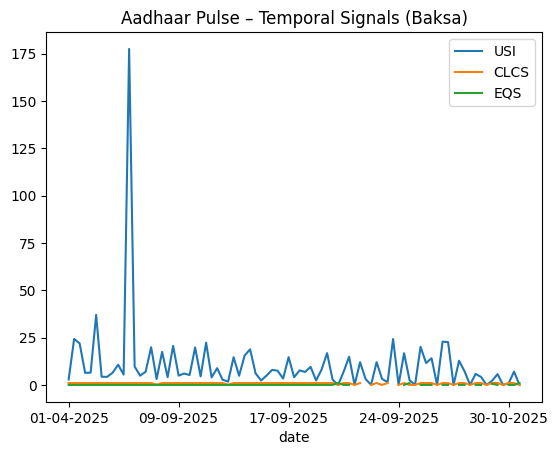

In [10]:
example_district = merged['district'].iloc[0]

merged[merged['district'] == example_district] \
    .set_index('date')[['USI', 'CLCS', 'EQS']] \
    .plot(title=f"Aadhaar Pulse – Temporal Signals ({example_district})")


In [16]:
enrol[['age_0_5', 'age_5_17', 'age_18_greater']].describe()


,age_0_5,age_5_17,age_18_greater
count,66749.000000,66749.000000,66749.000000
mean,53.138849,25.773929,2.522180
std,135.836947,118.131864,27.573139
min,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000
50%,24.000000,5.000000,0.000000
75%,62.000000,20.000000,0.000000
max,6740.000000,6314.000000,2404.000000


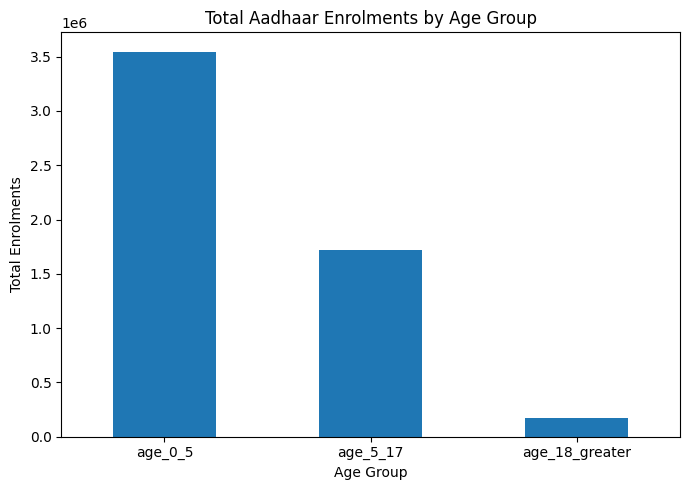

In [18]:
import matplotlib.pyplot as plt

age_totals = enrol[['age_0_5', 'age_5_17', 'age_18_greater']].sum()

plt.figure(figsize=(7,5))
age_totals.plot(kind='bar')

plt.title('Total Aadhaar Enrolments by Age Group')
plt.ylabel('Total Enrolments')
plt.xlabel('Age Group')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [20]:
# Aggregate demographic updates by age group
demo_totals = {
    'Age 5–17': demo['demo_age_5_17'].sum(),
    'Age 17+': demo['demo_age_17_plus'].sum()
}

# Aggregate biometric updates by age group
bio_totals = {
    'Age 5–17': bio['bio_age_5_17'].sum(),
    'Age 17+': bio['bio_age_17_plus'].sum()
}


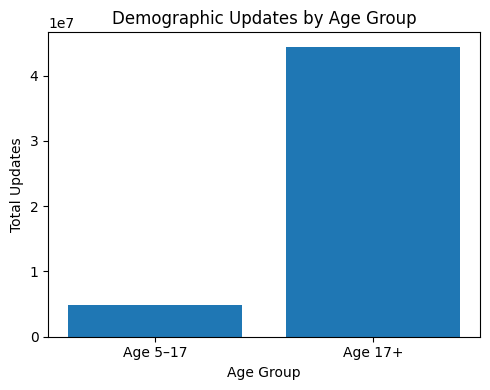

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.bar(demo_totals.keys(), demo_totals.values())

plt.title('Demographic Updates by Age Group')
plt.ylabel('Total Updates')
plt.xlabel('Age Group')

plt.tight_layout()
plt.show()


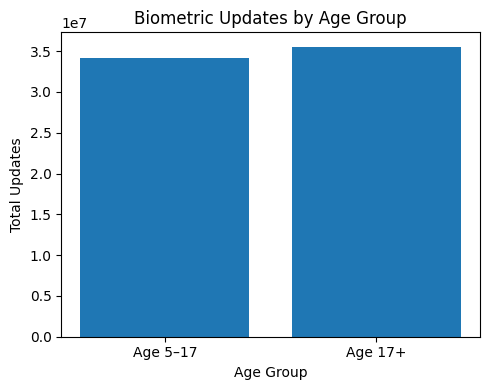

In [22]:
plt.figure(figsize=(5,4))
plt.bar(bio_totals.keys(), bio_totals.values())

plt.title('Biometric Updates by Age Group')
plt.ylabel('Total Updates')
plt.xlabel('Age Group')

plt.tight_layout()
plt.show()


In [28]:
# Aggregate enrolments per district
district_enrol = (
    enrol_agg
    .groupby('district')[['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
    .sum(axis=1)
)

# Aggregate updates per district
district_updates = (
    demo_agg
    .groupby('district')[['demo_age_5_17', 'demo_age_17_plus']]
    .sum()
    .sum(axis=1)
    +
    bio_agg
    .groupby('district')[['bio_age_5_17', 'bio_age_17_plus']]
    .sum()
    .sum(axis=1)
)

bivariate_df = pd.DataFrame({
    'Total Enrolments': district_enrol,
    'Total Updates': district_updates
}).dropna()


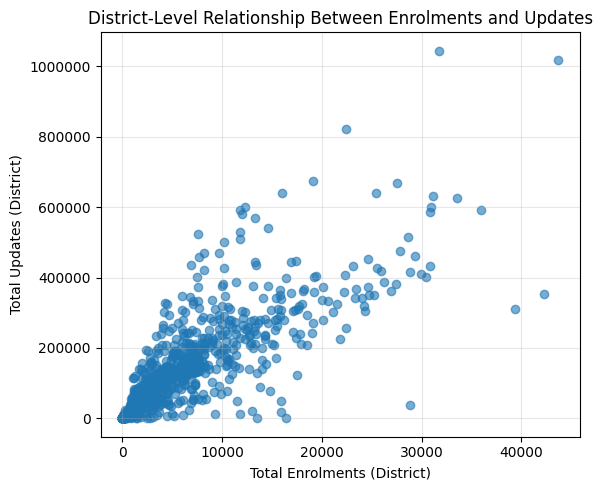

In [29]:
plt.figure(figsize=(6,5))
plt.scatter(
    bivariate_df['Total Enrolments'],
    bivariate_df['Total Updates'],
    alpha=0.6
)

plt.xlabel('Total Enrolments (District)')
plt.ylabel('Total Updates (District)')
plt.title('District-Level Relationship Between Enrolments and Updates')

plt.ticklabel_format(style='plain', axis='both')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
tri_df = enrol_agg.merge(
    bio_agg,
    on=['date', 'state', 'district'],
    how='left'
).fillna(0)

tri_df['child_update_ratio'] = (
    tri_df['bio_age_5_17'] / (tri_df['age_5_17'] + 1)
)

tri_df['adult_update_ratio'] = (
    tri_df['bio_age_17_plus'] / (tri_df['age_18_greater'] + 1)
)


C:\Users\Anmol Sriwastava\AppData\Local\Temp\ipykernel_43164\1307832989.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


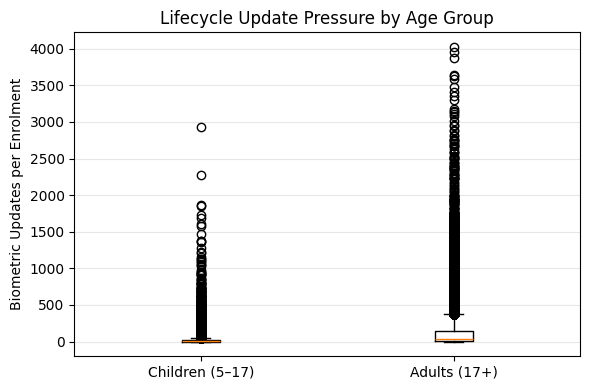

In [31]:
plt.figure(figsize=(6,4))
plt.boxplot(
    [tri_df['child_update_ratio'], tri_df['adult_update_ratio']],
    labels=['Children (5–17)', 'Adults (17+)']
)

plt.ylabel('Biometric Updates per Enrolment')
plt.title('Lifecycle Update Pressure by Age Group')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


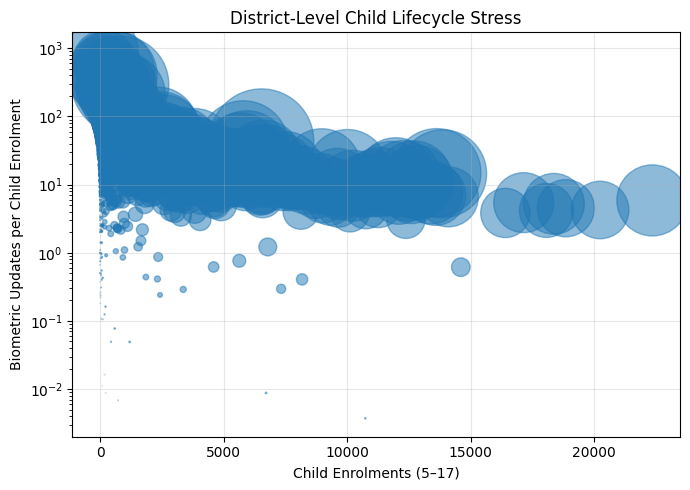

In [32]:
# Aggregate child enrolments and updates at district level
child_tri = (
    enrol_agg[['district', 'age_5_17']]
    .groupby('district')
    .sum()
    .merge(
        bio_agg[['district', 'bio_age_5_17']]
        .groupby('district')
        .sum(),
        on='district',
        how='left'
    )
    .fillna(0)
)

# Compute child update ratio
child_tri['child_update_ratio'] = (
    child_tri['bio_age_5_17'] / (child_tri['age_5_17'] + 1)
)

# Plot
plt.figure(figsize=(7,5))
plt.scatter(
    child_tri['age_5_17'],
    child_tri['child_update_ratio'],
    s=child_tri['bio_age_5_17'] / 50,  # bubble size
    alpha=0.5
)

plt.xlabel('Child Enrolments (5–17)')
plt.ylabel('Biometric Updates per Child Enrolment')
plt.title('District-Level Child Lifecycle Stress')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
